In [66]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

import shapefile as sf
from pyproj import Proj
from censusgeocode import CensusGeocode

import datetime

%matplotlib inline

In [8]:
sl_reader = sf.Reader('shapefiles/Street_Light/Street_Light.shp')
sl_record = pd.DataFrame(sl_reader.records())
sl_shapes = sl_reader.shapes()

In [4]:
# Need to convert each Street Light location to latitude and longitude
sl_record['lon'] = None
sl_record['lat'] = None

In [9]:
p1 = Proj("+init=EPSG:2230", preserve_units=True)
print len(sl_record)
for i in range(0,len(sl_record)): 
    lon, lat = p1(sl_shapes[i].points[0][0], sl_shapes[i].points[0][1],inverse=True)
    sl_record.loc[i, 'lon'] = lon 
    sl_record.loc[i, 'lat'] = lat
    if (i % 1000==0):
        print i, i, i 

48455
0 0 0
500 500 500
1000 1000 1000
1500 1500 1500
2000 2000 2000
2500 2500 2500
3000 3000 3000
3500 3500 3500
4000 4000 4000
4500 4500 4500
5000 5000 5000
5500 5500 5500
6000 6000 6000
6500 6500 6500
7000 7000 7000
7500 7500 7500
8000 8000 8000
8500 8500 8500
9000 9000 9000
9500 9500 9500
10000 10000 10000
10500 10500 10500
11000 11000 11000
11500 11500 11500
12000 12000 12000
12500 12500 12500
13000 13000 13000
13500 13500 13500
14000 14000 14000
14500 14500 14500
15000 15000 15000
15500 15500 15500
16000 16000 16000
16500 16500 16500
17000 17000 17000
17500 17500 17500
18000 18000 18000
18500 18500 18500
19000 19000 19000
19500 19500 19500
20000 20000 20000
20500 20500 20500
21000 21000 21000
21500 21500 21500
22000 22000 22000
22500 22500 22500
23000 23000 23000
23500 23500 23500
24000 24000 24000
24500 24500 24500
25000 25000 25000
25500 25500 25500
26000 26000 26000
26500 26500 26500
27000 27000 27000
27500 27500 27500
28000 28000 28000
28500 28500 28500
29000 29000 29000
2950

Associate each street light with its associated block group and census tract.

In [14]:
cg = CensusGeocode()

In [15]:
sl_record.loc[i, 'block'] = None
sl_record.loc[i, 'tract'] = None
sl_record.loc[i, 'geoid'] = None
sl_record.loc[i, 'blockgroup'] = None

In [45]:
start = datetime.datetime.now()

print len(sl_record)

for i in range(46956,len(sl_record)): 
    if ((sl_record.loc[i,'lon']!=0.0) 
        & (np.isnan(sl_record.loc[i,'lon'])==False)) :
        temp1 = cg.coordinates(x=sl_record.loc[i,'lon'], 
                              y=sl_record.loc[i, 'lat'])
        if (len(temp1[0]['2010 Census Blocks'])>0):
            if ('status' not in temp1[0]['2010 Census Blocks'][0].keys()[0]): 
                temp = temp1[0]['2010 Census Blocks'][0]
                if (temp is not None):
                    sl_record.loc[i, 'block'] = temp['BLOCK']
                    sl_record.loc[i, 'tract'] = temp['TRACT']
                    sl_record.loc[i, 'geoid'] = temp['GEOID']
                    sl_record.loc[i, 'blockgroup'] = temp['BLKGRP']

                if (i % 100 == 0): 
                    finish = datetime.datetime.now()
                    print i, finish-start
                    start = datetime.datetime.now()



48455
47000 0:00:51.430666
47100 0:01:44.302094
47200 0:02:20.313068
47300 0:02:40.013126
47400 0:02:49.721932
47500 0:02:26.032445
47600 0:02:18.374865
47700 0:02:01.482173
47800 0:02:16.113438
47900 0:01:50.279062
48000 0:01:21.353079
48100 0:02:07.290142
48200 0:02:04.870696
48300 0:02:11.107390
48400 0:01:12.004652


In [48]:
print i

48454


In [49]:
sl_record.to_csv('output_files/sl_records_all.csv')

In [77]:
# Read in block group shapefiles
reader = sf.Reader('shapefiles/tl_2016_06_bg/tl_2016_06_bg.shp')
bg_info2 = pd.DataFrame(reader.records())

In [78]:
bg_info2.rename(columns={0: 'statecode', 2: 'tract', 3: 'blockgroup', 
                        8: 'landarea', 10: 'cent_lat', 11: 'cent_lon'}, inplace=True)

In [79]:
sl_record['count'] = 0.0

In [80]:
# Number of street lights for each tract and block group
streetlight_count = sl_record[['tract', 'blockgroup', 'count']].groupby(['tract','blockgroup'], as_index=False).agg('count')

In [62]:
# Match up the streetlight counts with the area of each block group 
# to calculate typical street light density
#bg_info2['tract'] = bg_info2['tract'].astype(float)
#bg_info2['blockgroup'] = bg_info2['blockgroup'].astype(float)

In [81]:
print streetlight_count[['tract', 'blockgroup']].head()

print bg_info2[['tract', 'blockgroup']].head()

    tract blockgroup
0  000100          1
1  000100          2
2  000201          1
3  000202          1
4  000202          2
    tract blockgroup
0  940000          3
1  010800          2
2  010800          1
3  011100          3
4  010013          2


### Calculate Street Light density

In [82]:
big_streetlight = pd.merge(streetlight_count[['tract', 'blockgroup', 'count']], bg_info2, on=['tract', 'blockgroup'], how='left')

In [83]:
# Calculate street light density (per meters squared)
big_streetlight['sl_density'] = big_streetlight['count'] / big_streetlight['landarea']

In [124]:
big_streetlight[['tract', 'blockgroup', 'count', 'landarea', 
                 'cent_lat', 'cent_lon', 'sl_density']].to_csv('output_files/streetlight_density.csv', index=False)

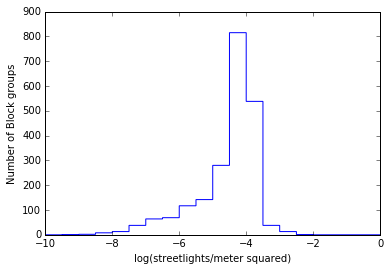

In [135]:
a = plt.hist(np.log10(big_streetlight['sl_density']), bins=20, range=[-10,0], histtype='step')
plt.xlabel('log(streetlights/meter squared)')
plt.ylabel('Number of Block groups')

In [123]:
big_streetlight.columns.values

array(['tract', 'blockgroup', 'count', 'statecode', 1, 4, 5, 6, 7,
       'landarea', 9, 'cent_lat', 'cent_lon', 'sl_density'], dtype=object)

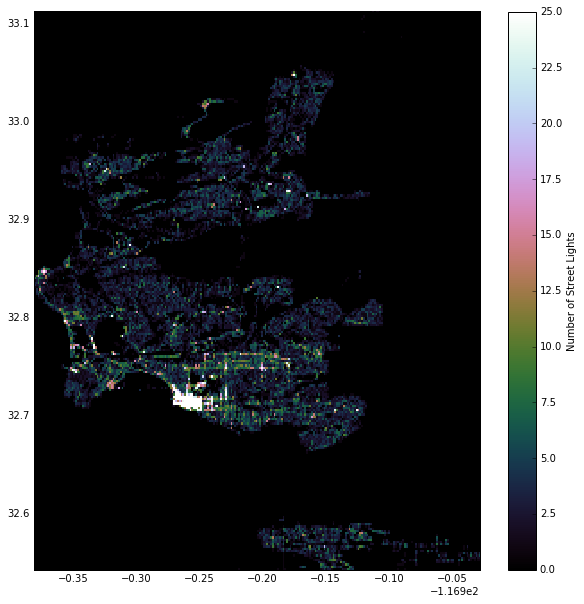

In [85]:
fig,ax = plt.subplots(1,1, figsize=(10,10))

plt.hist2d(sl_record['lon'], sl_record['lat'], bins=(250,250), cmap='cubehelix', vmax=25)
plt.colorbar(label='Number of Street Lights')

In [86]:
reader = sf.Reader('shapefiles/tl_2016_06_bg/tl_2016_06_bg.shp')
bg_info = pd.DataFrame(reader.records())
shapes = reader.shapes()
# the San Diego county shapefile records
sdcounty = bg_info.loc[np.where((bg_info[1]=='073') & (bg_info[3]!='0'))[0]]
sdcounty_index = np.where((bg_info[1]=='073') & (bg_info[3]!='0'))[0]

In [90]:
sdcounty['tract'] = sdcounty[2]
sdcounty['blockgroup'] = sdcounty[3]

In [105]:
yak = pd.read_csv('aff_download_city_bg2/DEC_10_PL_G001_with_ann.csv', header=1)
yak.rename(columns={'GEOGRAPHIC AREA CODES - Census Tract': 'tract', 
                   'GEOGRAPHIC AREA CODES - Block Group': 'blockgroup'}, inplace=True)

sdcity_census_tracts = yak['tract']
sdcity_census_blockgroups = yak['blockgroup']

In [108]:
to_ignore = ['021600', '020706', '021304', '013206', '013419', '013314', '017020', 
            '020709', '017106', '002201', '020801', '017106', '017106', '017110', 
            '020709', '021600', '020709', '021304', '013313', '017020', '011802', 
            '011802', '011902', '010502', '010601', '013419', '013206', '014700',
            '021900', '014700', '017006', '017106', '021900', '010601', '017304', 
            '017305', '021302']

(-117.3, -116.84999999999999, 32.5, 33.200000000000003)

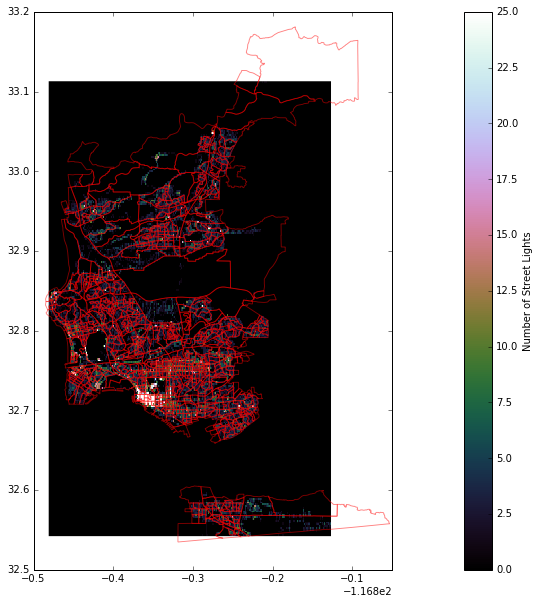

In [121]:
fig,ax = plt.subplots(1,1, figsize=(10,10))

patches = []
for i in range(0,len(sdcounty_index)): 
    #if sdcounty.loc[sdcounty_index[i], 'tract'] in list(sdcity_census_tracts):
    #    if (sdcounty.loc[sdcounty_index[i], 'tract'] not in to_ignore):
    temp_tract = sdcounty.loc[sdcounty_index[i], 'tract']
    temp_bg = sdcounty.loc[sdcounty_index[i], 'blockgroup']
    if (len(np.where((streetlight_count['tract']==temp_tract) & (streetlight_count['blockgroup']==temp_bg))[0])==1): 
            barf = pd.DataFrame(shapes[sdcounty_index[i]].points)
            poly = plt.Polygon(barf[[0,1]], fc='none', ec='r', alpha=0.5, lw=0.9, zorder=3)
            patches.append(poly)
            plt.gca().add_patch(poly)

plt.hist2d(sl_record['lon'], sl_record['lat'], bins=(250,250), cmap='cubehelix', vmax=25)
plt.colorbar(label='Number of Street Lights')        
        

plt.xlim(-117.28, -116.95)
plt.ylim(32.5,33.1)
plt.axis('scaled')